# Lefebvre et al. (2017) Analysis

## Behavioral and neural characterization of optimistic reinforcement learning

This notebook reproduces the model comparison analysis from Lefebvre et al. (2017).

**Reference**: Lefebvre, G., Lebreton, M., Meyniel, F., Bourgeois-Gironde, S., & Palminteri, S. (2017). Behavioural and neural characterization of optimistic reinforcement learning. *Nature Human Behaviour*, 1(4), 1-9.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import myplotlib as my
from pathlib import Path
import glob

from agent_rl import (
    AgentVars,
    DualLearningRateAgent,
    SingleLearningRateAgent,
    TaskVars,
    MultipleStateTask,
    agent_task_interaction,
    EstimationVars,
    Estimation,
)
from agent_rl.data_utils import load_lefebvre_subject, get_lefebvre_task_vars

%matplotlib inline

## 1. Load and Visualize Data

### Experiment 1: 50 subjects, 96 trials each

The task has 4 conditions with different reward probabilities:
- **State 0**: 75/25 (best option has 75% win probability)
- **State 1**: 25/25 (both options equally bad)
- **State 2**: 25/75 (best option has 75% win probability)
- **State 3**: 75/75 (both options equally good)

Each state appears 24 times in randomized order.

In [2]:
# Load example subject
example_subject = load_lefebvre_subject("../data/lefebvre2017/data_exp1/exp1_1.mat", experiment=1)
print(f"Data shape: {example_subject.shape}")
print(f"\nFirst 10 trials:")
display(example_subject.head(10))

print(f"\nTrials per state:")
print(example_subject.groupby('s').size())

Data shape: (96, 6)

First 10 trials:


,subject,block,trial,s,a,r
0,1,0,0,2,0,0.0
1,1,0,1,3,1,0.5
2,1,0,2,3,1,0.5
3,1,0,3,2,0,0.0
4,1,0,4,0,1,0.0
5,1,0,5,0,0,0.0
6,1,0,6,1,0,0.5
7,1,0,7,2,0,0.0
8,1,0,8,3,1,0.0
9,1,0,9,2,1,0.0



Trials per state:
s
0    24
1    24
2    24
3    24
dtype: int64


In [3]:
# Get task configuration and list all subject files
task_vars = get_lefebvre_task_vars(experiment=1)
data_dir = "../data/lefebvre2017/data_exp1"
files = sorted(glob.glob(f"{data_dir}/exp1_*.mat"))
print(f"Found {len(files)} subjects in Experiment 1")

# Task structure
print("\nTask structure (reward probabilities per state):")
print("  State 0: 75/25 - asymmetric, option 0 better")
print("  State 1: 25/75 - asymmetric, option 1 better") 
print("  State 2: 75/75 - symmetric, both good")
print("  State 3: 25/25 - symmetric, both bad")

Found 50 subjects in Experiment 1

Task structure (reward probabilities per state):
  State 0: 75/25 - asymmetric, option 0 better
  State 1: 25/75 - asymmetric, option 1 better
  State 2: 75/75 - symmetric, both good
  State 3: 25/25 - symmetric, both bad


## 2. Visualize Behavioral Data

Before fitting models, let's examine the behavioral patterns across all subjects.

In [4]:
# Load all subjects' data
all_data = []
for i, matfile in enumerate(files):
    data = load_lefebvre_subject(matfile, experiment=1)
    data['subject'] = i + 1
    all_data.append(data)
all_data = pd.concat(all_data, ignore_index=True)

# Define correct choice for each state (which option has higher reward probability)
# State 0: 75/25 -> option 0 is correct
# State 1: 25/75 -> option 1 is correct
# States 2,3: symmetric, no "correct" answer
correct_map = {0: 0, 1: 1, 2: None, 3: None}
all_data['correct'] = all_data.apply(
    lambda row: row['a'] == correct_map[row['s']] if correct_map[row['s']] is not None else np.nan, 
    axis=1
)

print(f"Total trials: {len(all_data)}")
print(f"Subjects: {all_data['subject'].nunique()}")

Total trials: 4800
Subjects: 50


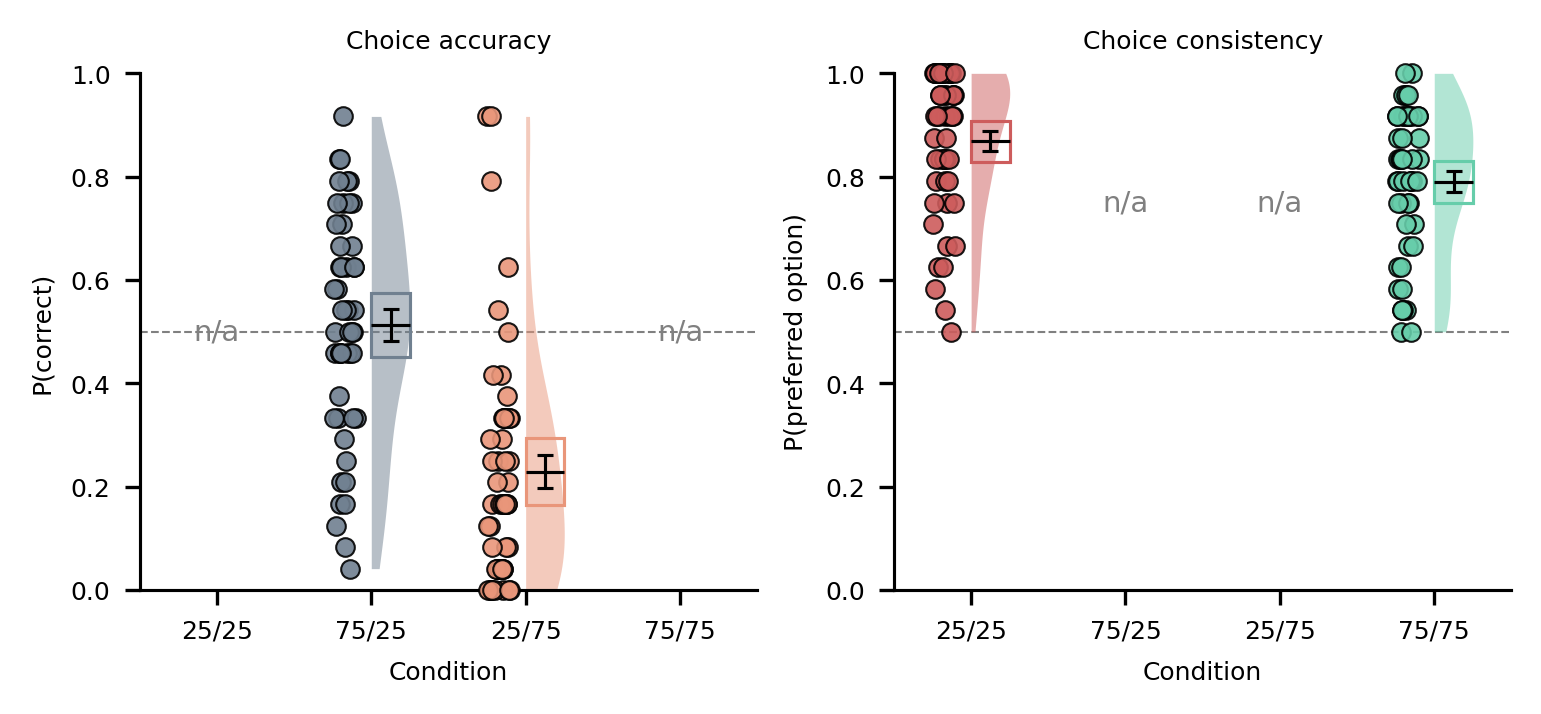

In [5]:
# Aggregate behavior plot with raincloud visualization
# Using Experiment 1 data only
import matplotlib
matplotlib = my.utilities.set_mpl_defaults(matplotlib)

from myplotlib.plots import raincloud

# Calculate per-subject statistics (using all_data from previous cell)
subject_stats = []
for subj in all_data['subject'].unique():
    subj_data = all_data[all_data['subject'] == subj]
    
    stats_row = {'subject': subj}
    for state in range(4):
        state_data = subj_data[subj_data['s'] == state]
        
        # Accuracy (proportion correct) - only for asymmetric states
        if correct_map[state] is not None:
            accuracy = (state_data['a'] == correct_map[state]).mean()
            stats_row[f'accuracy_s{state}'] = accuracy
        else:
            stats_row[f'accuracy_s{state}'] = np.nan
        
        # Preferred option frequency (max of p(option 0), p(option 1))
        p_option0 = (state_data['a'] == 0).mean()
        p_option1 = (state_data['a'] == 1).mean()
        preferred_freq = max(p_option0, p_option1)
        stats_row[f'preferred_s{state}'] = preferred_freq
    
    subject_stats.append(stats_row)

subject_stats_df = pd.DataFrame(subject_stats)

# Create figure with two panels - matching the model comparison figure style exactly
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=my.utilities.cm2inch((13, 6)))

# State order: 25/25, 75/25, 25/75, 75/75 (positions 0, 1, 2, 3)
state_labels = ['25/25', '75/25', '25/75', '75/75']

# Panel 1: Accuracy by state
# Only 75/25 (state 0) and 25/75 (state 1) have accuracy - plot at positions 1 and 2
accuracy_df = pd.DataFrame({
    '75/25': subject_stats_df['accuracy_s0'],
    '25/75': subject_stats_df['accuracy_s1'],
})

# Add chance line
ax1.axhline(0.5, color='gray', linestyle='--', linewidth=0.5, zorder=0)

# Raincloud plot with scatter/violins matching model comparison plot style
raincloud(accuracy_df, ax=ax1, x=[1, 2], colors=['C0', 'C1'],
          scatter_kws=dict(s=20, lw=0.5, alpha=0.9, dodge=0.25, jitter=0.15),
          violin_kws=dict(alpha=0.5, width=0.5),
          box_kws=dict(lw=0.75, width=0.25, capsize=2, ci_alpha=0.95))

# Add n/a annotations for symmetric states (positions 0 and 3)
ax1.text(0, 0.5, 'n/a', ha='center', va='center', color='gray', fontsize=7)
ax1.text(3, 0.5, 'n/a', ha='center', va='center', color='gray', fontsize=7)

ax1.set_xticks([0, 1, 2, 3])
ax1.set_xticklabels(state_labels)
ax1.set_ylabel('P(correct)')
ax1.set_xlabel('Condition')
ax1.set_title('Choice accuracy')
ax1.set_ylim(0, 1)
ax1.set_xlim(-0.5, 3.5)

# Panel 2: Preferred option frequency by state
# Only 75/75 (state 2) and 25/25 (state 3) are meaningful - plot at positions 0 and 3
preferred_df = pd.DataFrame({
    '25/25': subject_stats_df['preferred_s3'],
    '75/75': subject_stats_df['preferred_s2'],
})

# Add chance line
ax2.axhline(0.5, color='gray', linestyle='--', linewidth=0.5, zorder=0)

# Raincloud plot at positions 0 and 3
raincloud(preferred_df, ax=ax2, x=[0, 3], colors=['C3', 'C2'],
          scatter_kws=dict(s=20, lw=0.5, alpha=0.9, dodge=0.25, jitter=0.15),
          violin_kws=dict(alpha=0.5, width=0.5),
          box_kws=dict(lw=0.75, width=0.25, capsize=2, ci_alpha=0.95))

# Add n/a annotations for asymmetric states (positions 1 and 2)
ax2.text(1, 0.75, 'n/a', ha='center', va='center', color='gray', fontsize=7)
ax2.text(2, 0.75, 'n/a', ha='center', va='center', color='gray', fontsize=7)

ax2.set_xticks([0, 1, 2, 3])
ax2.set_xticklabels(state_labels)
ax2.set_ylabel('P(preferred option)')
ax2.set_xlabel('Condition')
ax2.set_title('Choice consistency')
ax2.set_ylim(0, 1)
ax2.set_xlim(-0.5, 3.5)

plt.tight_layout()
plt.show()

## 3. Model Fitting

We fit two reinforcement learning models to each subject's data:

1. **1LR Model (Single Learning Rate)**: Standard Q-learning with one learning rate α for all prediction errors
2. **2LR Model (Dual Learning Rate)**: Asymmetric learning with separate rates α+ (gains) and α- (losses)

Both models use a softmax decision rule with inverse temperature β.

### 3.1 Fit 1LR Model

In [6]:
# Setup 1LR estimation
est_vars_1lr = EstimationVars(
    task_vars=task_vars,
    agent_class=SingleLearningRateAgent,
    parameters=["alpha", "beta"],
    bounds={
        "alpha": (0.0, 1.0),
        "beta": (0.1, 50.0),
    },
    n_sp=5,
    rand_sp=True,
    reset_q_each_block=False,
)

# Fit 1LR to all subjects
print("Fitting 1LR model to all subjects...")
results_1lr = []

for i, matfile in enumerate(files):
    print(f"  Subject {i+1}/{len(files)}...", end='\r')
    
    data = load_lefebvre_subject(matfile, experiment=1)
    
    # CRITICAL: Q_init = 0.25 for Experiment 1
    agent_vars = AgentVars()
    agent_vars.Q_init = np.ones((4, 2)) * 0.25
    
    estimator = Estimation(est_vars_1lr)
    nll, bic, params, _ = estimator.estimate(data, agent_vars=agent_vars, seed=i*100, debug=False)
    
    results_1lr.append({
        "subject": i + 1,
        "alpha_1lr": params[0],
        "beta_1lr": params[1],
        "nll_1lr": nll,
        "bic_1lr": bic,
    })

print(f"  Subject {len(files)}/{len(files)}... Done!")
results_1lr_df = pd.DataFrame(results_1lr)

print(f"\n1LR Model - Parameter estimates (mean ± std):")
print(f"  α:  {results_1lr_df['alpha_1lr'].mean():.3f} ± {results_1lr_df['alpha_1lr'].std():.3f}")
print(f"  β:  {results_1lr_df['beta_1lr'].mean():.2f} ± {results_1lr_df['beta_1lr'].std():.2f}")

Fitting 1LR model to all subjects...
  Subject 50/50... Done!

1LR Model - Parameter estimates (mean ± std):
  α:  0.283 ± 0.323
  β:  25.06 ± 20.03


### 3.2 Fit 2LR Model

In [7]:
# Setup 2LR estimation
est_vars_2lr = EstimationVars(
    task_vars=task_vars,
    agent_class=DualLearningRateAgent,
    parameters=["alpha_pos", "alpha_neg", "beta"],
    bounds={
        "alpha_pos": (0.0, 1.0),
        "alpha_neg": (0.0, 1.0),
        "beta": (0.1, 50.0),
    },
    n_sp=5,
    rand_sp=True,
    reset_q_each_block=False,
)

# Fit 2LR to all subjects
print("Fitting 2LR model to all subjects...")
results_2lr = []

for i, matfile in enumerate(files):
    print(f"  Subject {i+1}/{len(files)}...", end='\r')
    
    data = load_lefebvre_subject(matfile, experiment=1)
    
    # CRITICAL: Q_init = 0.25 for Experiment 1
    agent_vars = AgentVars()
    agent_vars.Q_init = np.ones((4, 2)) * 0.25
    
    estimator = Estimation(est_vars_2lr)
    nll, bic, params, _ = estimator.estimate(data, agent_vars=agent_vars, seed=i*100, debug=False)
    
    results_2lr.append({
        "subject": i + 1,
        "alpha_pos": params[0],
        "alpha_neg": params[1],
        "beta_2lr": params[2],
        "nll_2lr": nll,
        "bic_2lr": bic,
    })

print(f"  Subject {len(files)}/{len(files)}... Done!")
results_2lr_df = pd.DataFrame(results_2lr)

print(f"\n2LR Model - Parameter estimates (mean ± std):")
print(f"  α+: {results_2lr_df['alpha_pos'].mean():.3f} ± {results_2lr_df['alpha_pos'].std():.3f}")
print(f"  α-: {results_2lr_df['alpha_neg'].mean():.3f} ± {results_2lr_df['alpha_neg'].std():.3f}")
print(f"  β:  {results_2lr_df['beta_2lr'].mean():.2f} ± {results_2lr_df['beta_2lr'].std():.2f}")

Fitting 2LR model to all subjects...
  Subject 50/50... Done!

2LR Model - Parameter estimates (mean ± std):
  α+: 0.319 ± 0.305
  α-: 0.157 ± 0.278
  β:  25.54 ± 19.61


### 3.3 Summary Table

Model fitting results with NLL, BIC, model frequency, and parameter estimates (mean ± SEM).

In [8]:
# Merge results for model comparison
results = results_2lr_df.merge(results_1lr_df, on='subject')
results['delta_bic'] = results['bic_1lr'] - results['bic_2lr']  # Positive = 2LR better
results['best_model'] = results['delta_bic'].apply(lambda x: '2LR' if x > 0 else '1LR')

# Calculate summary statistics
n_subjects = len(results)
n_2lr_better = (results['best_model'] == '2LR').sum()
n_1lr_better = (results['best_model'] == '1LR').sum()

# Helper function for mean ± SEM formatting
def mean_sem(series, fmt=".2f"):
    return f"{series.mean():{fmt}} ± {series.sem():{fmt}}"

# Build summary table
summary_data = {
    'Model': ['1LR', '2LR'],
    'NLL': [
        mean_sem(results['nll_1lr']),
        mean_sem(results['nll_2lr'])
    ],
    'BIC': [
        mean_sem(results['bic_1lr']),
        mean_sem(results['bic_2lr'])
    ],
    'Model Frequency': [
        f"{n_1lr_better}/{n_subjects} ({100*n_1lr_better/n_subjects:.0f}%)",
        f"{n_2lr_better}/{n_subjects} ({100*n_2lr_better/n_subjects:.0f}%)"
    ],
    'α': [
        mean_sem(results['alpha_1lr'], ".3f"),
        '—'
    ],
    'α+': [
        '—',
        mean_sem(results['alpha_pos'], ".3f")
    ],
    'α-': [
        '—',
        mean_sem(results['alpha_neg'], ".3f")
    ],
    'β': [
        mean_sem(results['beta_1lr']),
        mean_sem(results['beta_2lr'])
    ],
    '1/β (temperature)': [
        mean_sem(1/results['beta_1lr'], ".3f"),
        mean_sem(1/results['beta_2lr'], ".3f")
    ]
}

summary_df = pd.DataFrame(summary_data)
print("Model Fitting Summary (Mean ± SEM)")
print("=" * 80)
display(summary_df)

Model Fitting Summary (Mean ± SEM)


,Model,NLL,BIC,Model Frequency,α,α+,α-,β,1/β (temperature)
0,1LR,45.48 ± 2.22,100.08 ± 4.43,22/50 (44%),0.283 ± 0.046,—,—,25.06 ± 2.83,0.127 ± 0.023
1,2LR,40.11 ± 2.30,93.92 ± 4.60,28/50 (56%),—,0.319 ± 0.043,0.157 ± 0.039,25.54 ± 2.77,0.098 ± 0.019


## 4. Model Comparison (BIC)

Compare the two models using BIC. Lower BIC = better model.

In [9]:
# Detailed model comparison statistics
print("Model Comparison Results:")
print(f"  2LR better: {n_2lr_better} subjects ({100*n_2lr_better/n_subjects:.1f}%)")
print(f"  1LR better: {n_1lr_better} subjects ({100*n_1lr_better/n_subjects:.1f}%)")
print(f"\n  Mean ΔBIC: {results['delta_bic'].mean():.2f} ± {results['delta_bic'].std():.2f}")
print(f"  When 2LR better: Mean ΔBIC = {results[results['delta_bic'] > 0]['delta_bic'].mean():.2f}")
print(f"  When 1LR better: Mean ΔBIC = {results[results['delta_bic'] < 0]['delta_bic'].mean():.2f}")

# Show examples
print("\nExample subjects:")
display(results[['subject', 'best_model', 'delta_bic', 'alpha_pos', 'alpha_neg', 'alpha_1lr']].head(10))

Model Comparison Results:
  2LR better: 28 subjects (56.0%)
  1LR better: 22 subjects (44.0%)

  Mean ΔBIC: 6.16 ± 12.64
  When 2LR better: Mean ΔBIC = 13.60
  When 1LR better: Mean ΔBIC = -3.31

Example subjects:


,subject,best_model,delta_bic,alpha_pos,alpha_neg,alpha_1lr
0,1,1LR,-1.780090,1.000000,0.733966,0.771529
1,2,1LR,-4.381451,0.783640,1.000000,0.983976
2,3,2LR,42.452953,0.079933,0.000000,0.110526
3,4,1LR,-3.844871,0.461610,0.791754,0.709818
4,5,2LR,5.736925,0.432353,0.000000,0.000000
5,6,1LR,-1.260951,0.156180,0.095949,0.134473
6,7,2LR,27.386006,0.240372,0.000000,0.133465
7,8,2LR,9.780255,0.267746,0.033089,0.138882
8,9,2LR,5.791739,0.017535,0.000000,0.008035
9,10,2LR,4.821740,1.000000,0.396165,0.468848


## 5. Visualization

Create two-panel figure:
- **Panel A**: BIC comparison (1LR vs 2LR)
- **Panel B**: 2LR parameter estimates (α+ vs α-), colored by best model

In [10]:
import matplotlib
matplotlib = my.utilities.set_mpl_defaults(matplotlib)

Saved: lefebvre_exp1_model_comparison.pdf


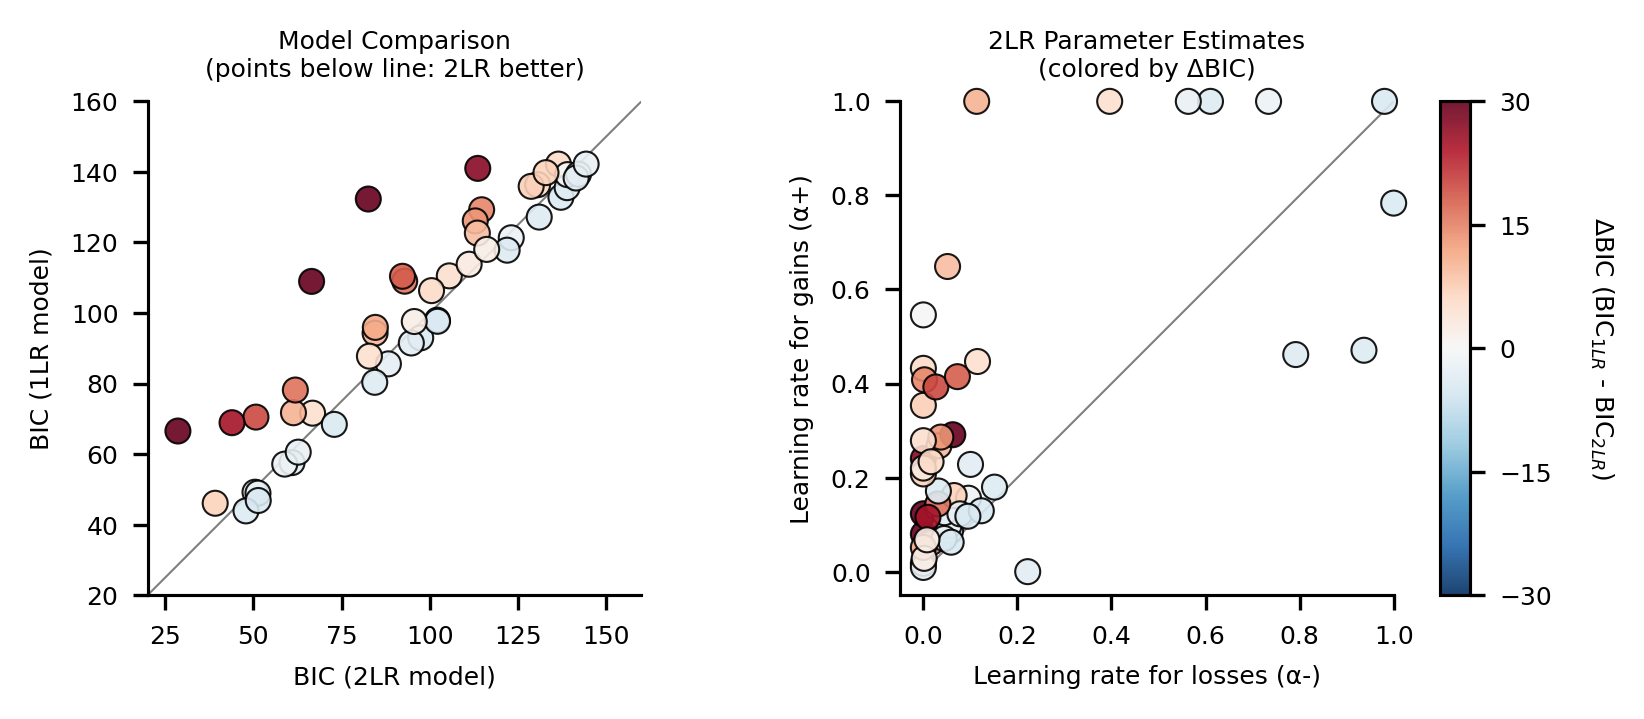

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=my.utilities.cm2inch((13, 6)))

cmap = matplotlib.colormaps['RdBu_r']
norm = matplotlib.colors.TwoSlopeNorm(vcenter=0, vmin=-30, vmax=30)

# Panel A: BIC comparison
ax1.scatter(results['bic_2lr'], results['bic_1lr'], 
           c=results['delta_bic'], cmap=cmap, norm=norm,
           edgecolors="black", linewidth=0.5, alpha=0.9
           )
ax1.plot([0, 200], [0, 200], 'k', linewidth=.5, alpha=0.5, zorder=-1)
ax1.set_xlabel('BIC (2LR model)')
ax1.set_ylabel('BIC (1LR model)')
ax1.set_title('Model Comparison\n(points below line: 2LR better)')
ax1.set_aspect('equal')
ax1.set_xlim(20, 160)
ax1.set_ylim(20, 160)

# Panel B: 2LR parameters colored by delta BIC
sc = ax2.scatter(
    results['alpha_neg'],
    results['alpha_pos'],
    c=results['delta_bic'], cmap=cmap, norm=norm,
    alpha=0.9, edgecolors='black', linewidth=0.5, clip_on=False
)

ax2.plot([0, 1], [0, 1], 'k', linewidth=.5, alpha=0.5, zorder=-1)
ax2.set_xlabel('Learning rate for losses (α-)')
ax2.set_ylabel('Learning rate for gains (α+)')
ax2.set_xlim(-0.05, 1.0)
ax2.set_ylim(-0.05, 1.0)
ax2.set_aspect('equal')
ax2.set_title('2LR Parameter Estimates\n(colored by ΔBIC)')

plt.tight_layout()

# Add colorbar manually positioned after tight_layout
# Get ax2 position and create colorbar axes to the right
ax2_pos = ax2.get_position()
cax = fig.add_axes([ax2_pos.x1 + 0.03, ax2_pos.y0, 0.02, ax2_pos.height])
cbar = fig.colorbar(sc, cax=cax, ticks=[-30, -15, 0, 15, 30])
cbar.set_label('ΔBIC (BIC$_{1LR}$ - BIC$_{2LR}$)', rotation=270, labelpad=15)

plt.savefig('lefebvre_exp1_model_comparison.pdf', bbox_inches='tight', dpi=300)
print("Saved: lefebvre_exp1_model_comparison.pdf")
plt.show()

## Summary

This notebook reproduced the model comparison from Lefebvre et al. (2017):

1. **Data**: 50 subjects, 96 trials each in a probabilistic learning task
2. **Models**: Compared single (1LR) vs dual (2LR) learning rate models
3. **Method**: Maximum likelihood estimation with BIC model comparison

### Key Findings:

- **Model comparison**: About 56% of subjects are better fit by 2LR, suggesting individual differences in learning asymmetries
- **Effect size**: When 2LR is better, the evidence is stronger (larger ΔBIC) than when 1LR is better
- **Learning biases**: Some individuals show optimistic learning (α+ > α-), others show pessimistic learning (α- > α+)

These results demonstrate that while many people exhibit asymmetric learning from gains vs losses, there is substantial individual variation in this bias.